In [4]:
import torch
from torch import nn, einsum
import numpy as np 

!pip install einops 
 
from einops import rearrange # Clear and Reliable Tensor Manipulations with Einstein-like notation

import torch.nn.functional as F

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 8.7 MB/s eta 0:00:00


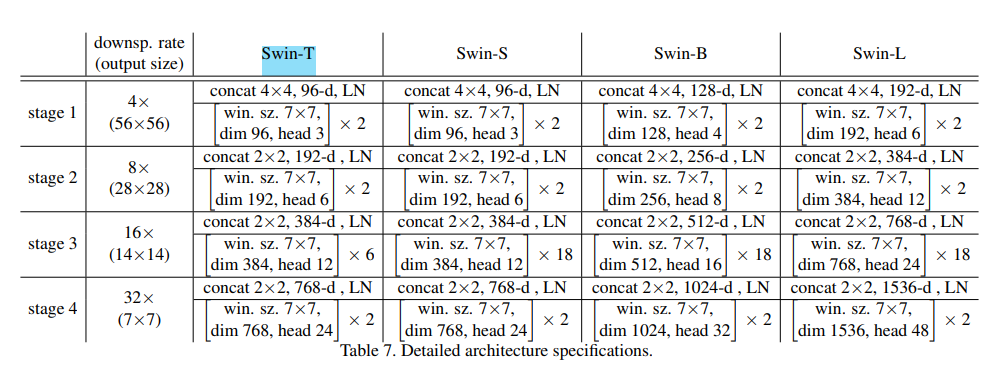


* Swin Transformer는 위와 같이 4개의 모델이 있는데 그중 Swin-Tiny에 대한 구현 코드

#### Cyclic Shift

* torch.roll을 사용하면 원하는 차원에 있는 값을 shift 할 수 있다.
* self.displacement = window_size // 2

In [5]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        # x.shape (b, 56, 56, 96)
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))  # 각 차원별로 3씩 밀어버림

##### skip connection and Layer Normalization

In [6]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

##### MLP

Encoder의 MLP구현

In [7]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

##### Mask

In [8]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

* cyclic shift 뒤에 수행할 마스킹 작업을 하는 함수



* 만약 window_size가 3이고 displacement가 1이라면 아래 사진에서 upper_lower 마스크는 왼쪽과 같고 left_right는 오른쪽과 같다.

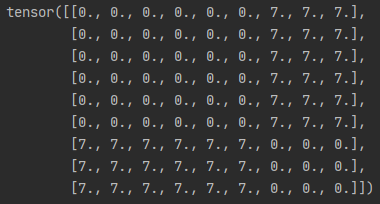

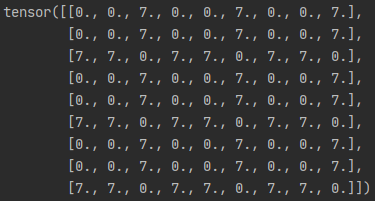

##### Relative Distance


window size를 받아서 상대거리를 반환하는 함수 ( [−M + 1, M −1] 사이의 수)

In [9]:
def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

##### W-MSA & SW-MSA

* Transformer의 Multi head Self-Attention을 수행하는 class로 block의 두번째 encoder인 SW-MSA 에서만 self.shifted=True가 되어서 cyclic shift + mask 를 진행한다.


* relative_position_embedding을 query와 key값의 dot product를 scale로 나눈값에 더해준다.

In [10]:
class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2  # 7//2 = 3
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            # self.relative_indices -> index (0~12 사이의 수를 가짐) / + window_size - 1 은 음수를 없애기 위해
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))  # (13, 13)
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)  # (b, 56, 56, 288) -> tuple len 3 (b, 56, 56, 96)
        nw_h = n_h // self.window_size  # 8
        nw_w = n_w // self.window_size  # 8

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        # (b, 3, 64, 49, 32), (b, 3, 64, 49, 32)  -> (b, 3, 64, 49, 49)
        # query와 key사이의 연관성(dot product) * scale(1 / root(head_dim))
        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0].type(torch.long),
                                       self.relative_indices[:, :, 1].type(torch.long)]  # (49, 49)
        else:
            dots += self.pos_embedding
        if self.shifted:  # masking
            dots[:, :, -nw_w:] += self.upper_lower_mask  # 아래쪽 가로모양 윈도우
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask  # 오른쪽 세로모양 마스킹

        attn = dots.softmax(dim=-1)
        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)  # shift한 값을 원래 위치로
        return out

##### Swin Transformer Block

* Swin Transformer를 구성하는 한개의 Encoder에 대한 구현이다.
* attention과 mlp 모두 Layer Normalization과 Skip Connection을 먼저 한다. (attention과 mlp가 뒤에 있다고 먼저 수행되는게 아님! (위에 Layer Normalization과 Residual 클래스 참고))

In [11]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

##### Patch Partition or Patch Merging & Linear Embedding

* downscaling_factor는 [4, 2, 2, 2] 로 이루어져 있기 때문에 stage1에서는 이미지가 패치로 partition 되고 그 이후 stage는 자동으로 patch merging 역할을 한다.



* Linear embedding에서 C는 각 stage에서 [96, 192, 384, 768]를 사용한다. 


In [12]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor  #  num patches (56 x 56)
        # self.patch_merge(x) : (b, 48, 3136)
        # self.patch_merge(x).view(b, -1, new_h, new_w) : (b, 48, 56, 56)
        # self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)  : (b, 56, 56, 48)
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)  # (b, 56, 56, 48) -> (b, 56, 56, 96)
        return x

##### StageModule

각 스테이지는 Patch partition(merging)과 Swin Block으로 이루어져 있으며 stage3에서는 Swin Block이 세번 반복된다.

In [13]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)  # (4, 56, 56, 96) -> (4, 96, 56, 56)

### Swin Transformer

4개의 stage를 거친 후에 나오는 7x7 patch를 average pooling (mean)을 하고 최종 classifier에 넣어 예측을 한다.

In [14]:
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()
        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        # input shape
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        # image shape(b, 3, 224, 224)
        x = self.stage1(img)  # (b, 96, 56, 56)
        x = self.stage2(x)  # (b, 192, 28, 28)
        x = self.stage3(x)  # (b, 384, 14, 14)
        x = self.stage4(x)  # (b, 768, 7, 7)

        x = x.mean(dim=[2, 3])  # (b, 768)
        return self.mlp_head(x)  # (b, classes)

##### Test Swin-Tiny



In [18]:
import torchsummary

def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

if __name__ == '__main__':
    import pdb
    from torchsummary import summary
    model = swin_t()
    x = torch.rand(4, 3, 224, 224)

    outputs = model(x)
    print(outputs.shape)

    summary(model, input_size=(3, 224, 224), device='cpu')

torch.Size([4, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1             [-1, 48, 3136]               0
            Linear-2           [-1, 56, 56, 96]           4,704
      PatchMerging-3           [-1, 56, 56, 96]               0
         LayerNorm-4           [-1, 56, 56, 96]             192
            Linear-5          [-1, 56, 56, 288]          27,648
            Linear-6           [-1, 56, 56, 96]           9,312
   WindowAttention-7           [-1, 56, 56, 96]               0
           PreNorm-8           [-1, 56, 56, 96]               0
          Residual-9           [-1, 56, 56, 96]               0
        LayerNorm-10           [-1, 56, 56, 96]             192
           Linear-11          [-1, 56, 56, 384]          37,248
             GELU-12          [-1, 56, 56, 384]               0
           Linear-13           [-1, 56, 56, 96]          36,960
      FeedForward